In [864]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from tqdm import tqdm_notebook
from itertools import product

import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

In [865]:
import pandas as pd
data = pd.read_feather("../01-data/processed/madrid_air_quality_data.feather")

The 5 main polutants are : no2_µg_m3, no_µg_m3, pm10_µg_m3, pm25_µg_m3 and o3_µg_m3.So they are the ones that we will predict.
In order to do so, we will create a dataframe for each one of them, including the polutant we want to predict and the other variables that will be useful for that specific case.In order to do so, we will perform the granularity test.We will use 0.05 as the p-value.

In [861]:
# we will be taking Pza. de España station as an example
data.set_index("time",inplace = True)
data.index = pd.to_datetime(data.index)
data = data[data["estacion"] == "Escuelas Aguirre"]
data = data.resample('1M').sum()
data = data.asfreq("M")

In [862]:
columns = ['ben_µg_m3', 'ch4_mg_m3', 'co_mg_m3', 'ebe_µg_m3', 'nmhc_mg_m3',
       'no2_µg_m3', 'no_µg_m3', 'nox_µg_m3', 'o3_µg_m3', 'pm10_µg_m3','pm25_µg_m3', 'so2_µg_m3', 'tch_mg_m3', 'tol_µg_m3',
       'traffic_intensity', 'traffic_load', 'u_wind_component_100m',
       'v_wind_component_100m', 'u_wind_component_10m', 'v_wind_component_10m',
       'temperature', 'mean_sea_level_pressure', 'surface_pressure',
       'total_precipitation']
for i in columns:
    data[i].fillna((data[i].mean()), inplace=True)
    if len(data[i].value_counts().index) == 1:
        data = data.drop(i,axis = 1)

## Performing a granularity test and creating a dataframe for each of the 5 polutants.

## no2_µg_m3

In [848]:
# Arturo Soria
for i in data.columns:
    print("\n")
    print(f"{i} causes no2_µg_m3")
    print('------------------')
    granger_1 = grangercausalitytests(data[['no2_µg_m3', i]], 4)
    
# p-value less than 0.05 in any of the first 4 lags: "no_µg_m3", "nox_µg_m3", "o3_µg_m3"
# we will be choosing

no2_µg_m3_dataframe = data[["no2_µg_m3","no_µg_m3","nox_µg_m3","o3_µg_m3"]]



ben_µg_m3 causes no2_µg_m3
------------------

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.3093  , p=0.1339  , df_denom=60, df_num=1
ssr based chi2 test:   chi2=2.4248  , p=0.1194  , df=1
likelihood ratio test: chi2=2.3793  , p=0.1230  , df=1
parameter F test:         F=2.3093  , p=0.1339  , df_denom=60, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.6413  , p=0.5304  , df_denom=57, df_num=2
ssr based chi2 test:   chi2=1.3950  , p=0.4978  , df=2
likelihood ratio test: chi2=1.3796  , p=0.5017  , df=2
parameter F test:         F=0.6413  , p=0.5304  , df_denom=57, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.4171  , p=0.7414  , df_denom=54, df_num=3
ssr based chi2 test:   chi2=1.4135  , p=0.7024  , df=3
likelihood ratio test: chi2=1.3974  , p=0.7062  , df=3
parameter F test:         F=0.4171  , p=0.7414  , df_denom=54, df_num=3

Granger Causality
number of lags (no zero) 4
ssr ba

In [849]:
rows = no2_µg_m3_dataframe.shape[0]
train_rows = int(rows*0.70)
train = no2_µg_m3_dataframe.iloc[:train_rows,:]
test = no2_µg_m3_dataframe.iloc[train_rows:,:]

In [850]:
model = VAR(train,freq = "1M")

In [851]:
sorted_order=model.select_order(maxlags=4)
print(sorted_order.summary())
# 3 is the best value for the number of lags

 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0       66.31       66.48   6.297e+28       66.37
1       64.80      65.64*   1.389e+28      65.10*
2       64.92       66.44   1.616e+28       65.47
3       64.56       66.76  1.207e+28*       65.36
4      64.47*       67.34   1.255e+28       65.51
-------------------------------------------------


In [852]:
var_model = VARMAX(train, order=(4,0),enforce_stationarity= True)
fitted_model = var_model.fit(disp=False)

In [853]:
n_forecast = no2_µg_m3_dataframe.shape[0]-len(train)
predict = fitted_model.get_prediction(start=len(train),end=len(train) + n_forecast-1)

predictions=predict.predicted_mean

In [854]:
predictions.columns=['no2_µg_m3_prediction','no_µg_m3_prediction','nox_µg_m3_prediction',"o3_µg_m3_prediciton"]
predictions.index = test.index

In [855]:
test_vs_pred=pd.concat([test["no2_µg_m3"],predictions["no2_µg_m3_prediction"]],axis=1)

<AxesSubplot:xlabel='time'>

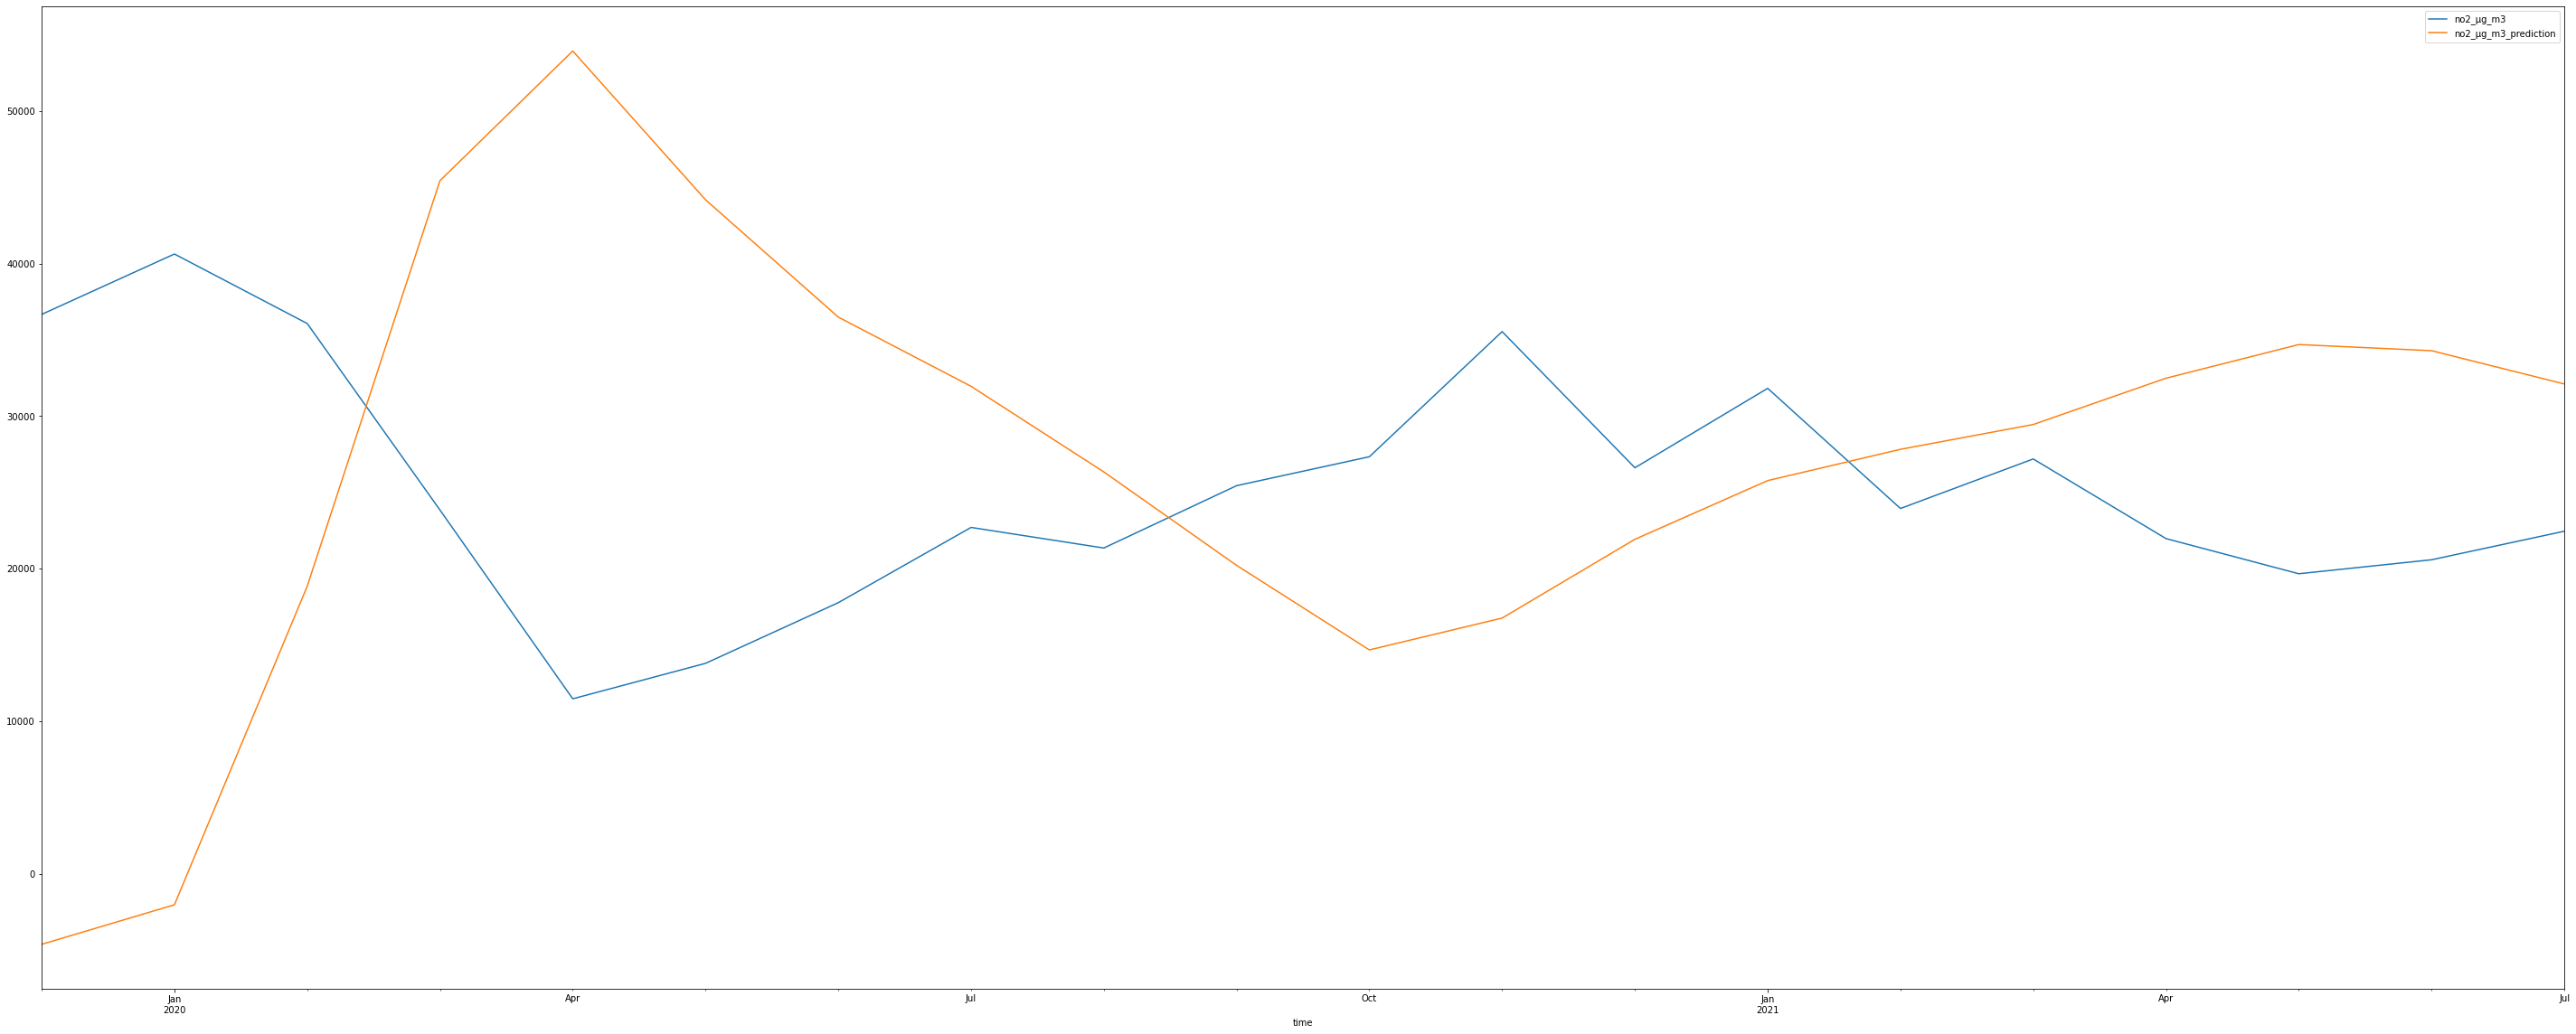

In [856]:
test_vs_pred.plot(figsize=(50,20))

In [857]:
number_of_predictions = test_vs_pred.shape[0]
error = 0
for i in range(number_of_predictions):
    e = abs(test_vs_pred.iloc[i,0]-test_vs_pred.iloc[i,1])
    error += e
print(error)
mean_absolute_error = error/number_of_predictions
print("The mean absolute error of this forecast is ",mean_absolute_error)

330879.4118770388
The mean absolute error of this forecast is  16543.97059385194


## no_µg_m3

In [818]:
# no_µg_m3
# Arturo Soria
for i in data.columns:
    print("\n")
    print(f"{i} causes no_µg_m3")
    print('------------------')
    granger_1 = grangercausalitytests(data[['no_µg_m3', i]], 4)
    
# p-value less than 0.05 in any of the first 4 lags: "no_µg_m3", "nox_µg_m3", "o3_µg_m3"
# we will be choosing

no_µg_m3_dataframe = data[["no_µg_m3","traffic_intensity","traffic_load"]]



ben_µg_m3 causes no_µg_m3
------------------

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0057  , p=0.9399  , df_denom=60, df_num=1
ssr based chi2 test:   chi2=0.0060  , p=0.9382  , df=1
likelihood ratio test: chi2=0.0060  , p=0.9382  , df=1
parameter F test:         F=0.0057  , p=0.9399  , df_denom=60, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.9237  , p=0.4029  , df_denom=57, df_num=2
ssr based chi2 test:   chi2=2.0096  , p=0.3661  , df=2
likelihood ratio test: chi2=1.9777  , p=0.3720  , df=2
parameter F test:         F=0.9237  , p=0.4029  , df_denom=57, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.4575  , p=0.7131  , df_denom=54, df_num=3
ssr based chi2 test:   chi2=1.5505  , p=0.6707  , df=3
likelihood ratio test: chi2=1.5311  , p=0.6751  , df=3
parameter F test:         F=0.4575  , p=0.7131  , df_denom=54, df_num=3

Granger Causality
number of lags (no zero) 4
ssr bas

In [819]:
rows = no_µg_m3_dataframe.shape[0]
train_rows = int(rows*0.70)
train = no_µg_m3_dataframe.iloc[:train_rows,:]
test = no_µg_m3_dataframe.iloc[train_rows:,:]

In [820]:
model = VAR(train,freq = "1M")

In [821]:
sorted_order=model.select_order(maxlags=6)

In [822]:
var_model = VARMAX(train, order=(8,0),enforce_stationarity= True)
fitted_model = var_model.fit(disp=False)

In [823]:
n_forecast = no_µg_m3_dataframe.shape[0]-len(train)
predict = fitted_model.get_prediction(start=len(train),end=len(train) + n_forecast-1)

predictions=predict.predicted_mean

In [824]:
predictions.columns=['no_µg_m3_prediction','traffic_intensity_prediction','traffic_load_prediction']
predictions.index = test.index

In [825]:
test_vs_pred=pd.concat([test["no_µg_m3"],predictions["no_µg_m3_prediction"]],axis=1)

<AxesSubplot:xlabel='time'>

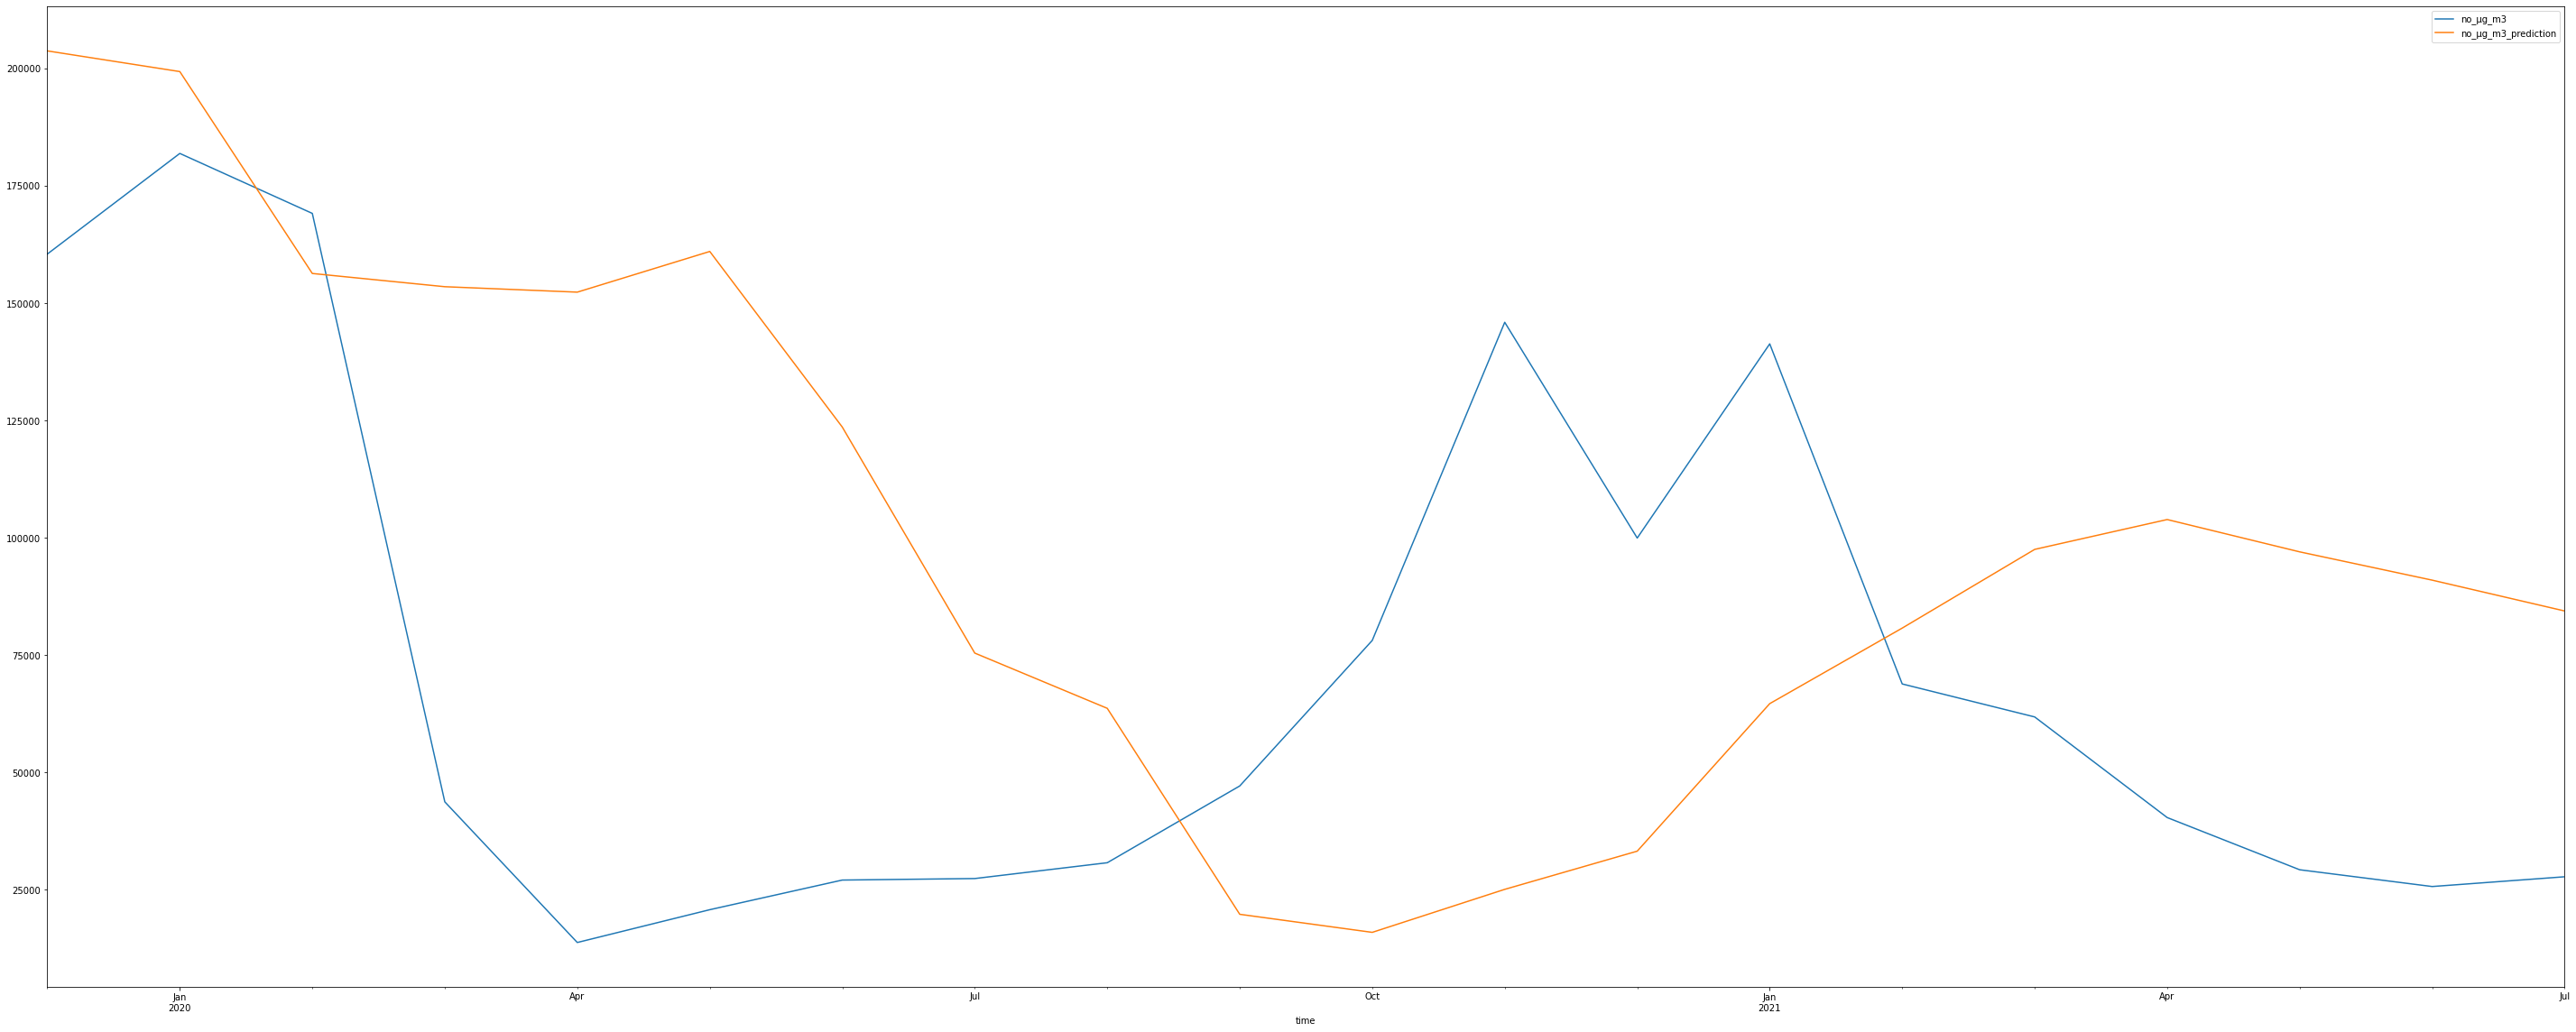

In [826]:
test_vs_pred.plot(figsize=(50,20))

In [827]:
number_of_predictions = test_vs_pred.shape[0]
error = 0
for i in range(number_of_predictions):
    e = abs(test_vs_pred.iloc[i,0]-test_vs_pred.iloc[i,1])
    error += e
print(error)
mean_absolute_error = error/number_of_predictions
print("The mean absolute error of this forecast is ",mean_absolute_error)

1294435.5862218523
The mean absolute error of this forecast is  64721.779311092614


## pm10_µg_m3

In [828]:
# pm10_µg_m3
# Escuelas Aguirre
for i in data.columns:
    print("\n")
    print(f"{i} causes pm10_µg_m3")
    print('------------------')
    granger_1 = grangercausalitytests(data[['pm10_µg_m3', i]], 4)
    
pm10_µg_m3_dataframe = data[["pm10_µg_m3","temperature","o3_µg_m3","no2_µg_m3"]]



ben_µg_m3 causes pm10_µg_m3
------------------

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.8054  , p=0.1841  , df_denom=60, df_num=1
ssr based chi2 test:   chi2=1.8957  , p=0.1686  , df=1
likelihood ratio test: chi2=1.8677  , p=0.1717  , df=1
parameter F test:         F=1.8054  , p=0.1841  , df_denom=60, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.0008  , p=0.3740  , df_denom=57, df_num=2
ssr based chi2 test:   chi2=2.1771  , p=0.3367  , df=2
likelihood ratio test: chi2=2.1397  , p=0.3431  , df=2
parameter F test:         F=1.0008  , p=0.3740  , df_denom=57, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.6492  , p=0.5869  , df_denom=54, df_num=3
ssr based chi2 test:   chi2=2.1999  , p=0.5320  , df=3
likelihood ratio test: chi2=2.1612  , p=0.5396  , df=3
parameter F test:         F=0.6492  , p=0.5869  , df_denom=54, df_num=3

Granger Causality
number of lags (no zero) 4
ssr b

In [829]:
rows = pm10_µg_m3_dataframe.shape[0]
train_rows = int(rows*0.70)
train = pm10_µg_m3_dataframe.iloc[:train_rows,:]
test = pm10_µg_m3_dataframe.iloc[train_rows:,:]
model = VAR(train,freq = "1M")

In [830]:
sorted_order=model.select_order(maxlags=6)
print(sorted_order.summary())

 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0       85.03       85.20   8.491e+36       85.09
1       81.65       82.51   2.889e+35       81.95
2       82.01       83.56   4.269e+35       82.56
3       82.07       84.31   4.911e+35       82.86
4       80.82       83.75   1.652e+35       81.86
5       79.54       83.16   6.091e+34       80.83
6      46.39*      50.70*  4.002e+20*      47.92*
-------------------------------------------------


<AxesSubplot:xlabel='time'>

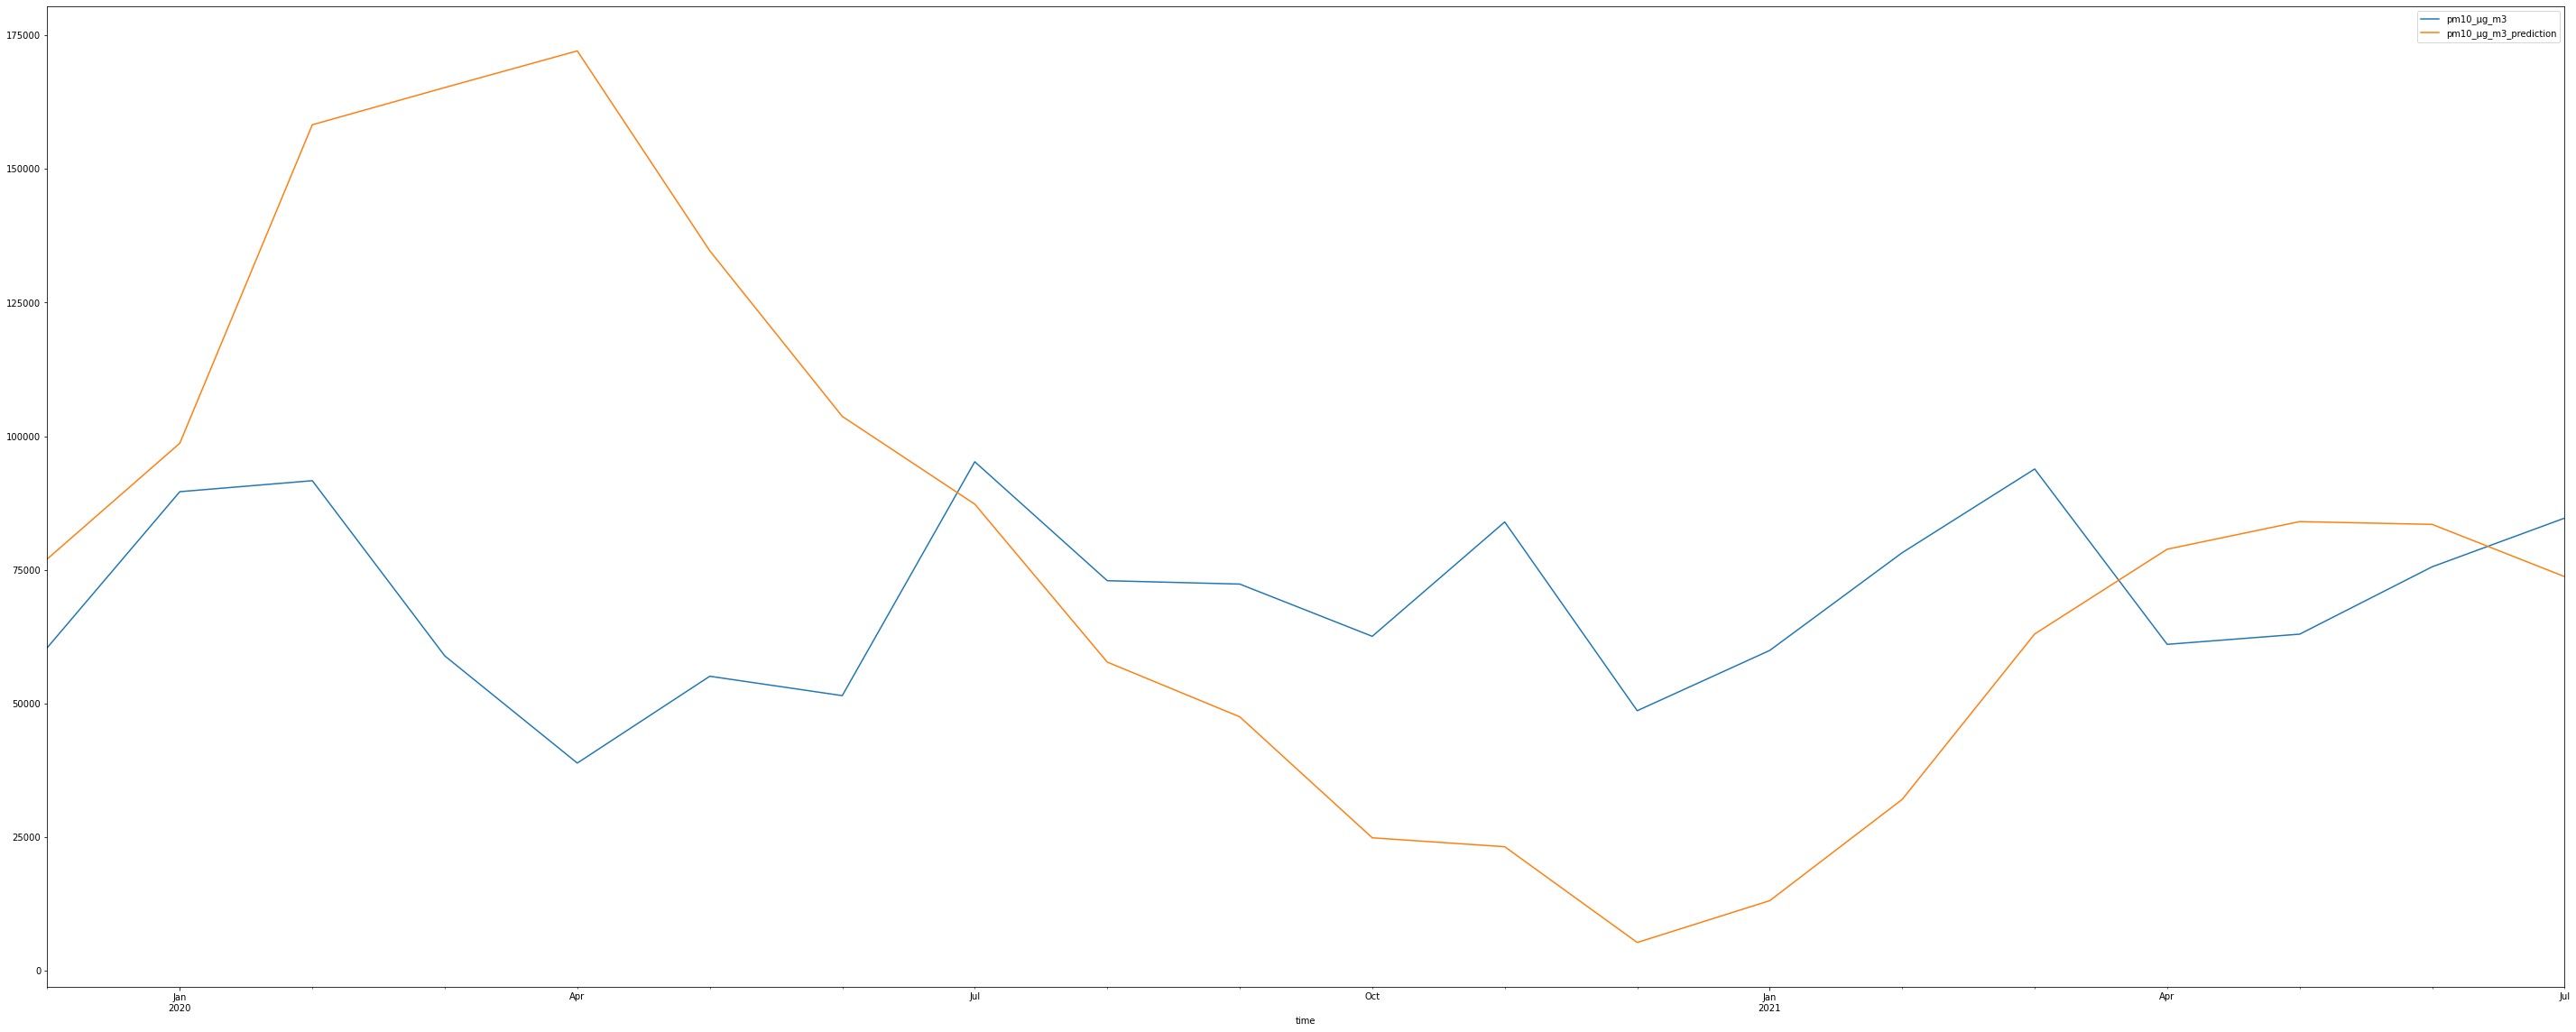

In [831]:
var_model = VARMAX(train, order=(6,0),enforce_stationarity= True)
fitted_model = var_model.fit(disp=False)

n_forecast = pm10_µg_m3_dataframe.shape[0]-len(train)
predict = fitted_model.get_prediction(start=len(train),end=len(train) + n_forecast-1)

predictions=predict.predicted_mean
predictions.columns=["pm10_µg_m3_prediction","temperature_predictions","o3_µg_m3_predictions","no2_µg_m3_predictions"]
predictions.index = test.index
test_vs_pred=pd.concat([test["pm10_µg_m3"],predictions["pm10_µg_m3_prediction"]],axis=1)
test_vs_pred.plot(figsize=(50,20))

In [832]:
number_of_predictions = test_vs_pred.shape[0]
error = 0
for i in range(number_of_predictions):
    e = abs(test_vs_pred.iloc[i,0]-test_vs_pred.iloc[i,1])
    error += e
print(error)
mean_absolute_error = error/number_of_predictions
print("The mean absolute error of this forecast is ",mean_absolute_error)

834735.2534833702
The mean absolute error of this forecast is  41736.76267416851


## pm25_µg_m3

In [833]:
# pm25_µg_m3
#Escuelas Aguirre
for i in data.columns:
    print("\n")
    print(f"{i} causes pm25_µg_m3")
    print('------------------')
    granger_1 = grangercausalitytests(data[['pm25_µg_m3', i]], 4)
    
pm25_µg_m3_dataframe = data[["pm25_µg_m3","traffic_intensity","traffic_load","u_wind_component_100m","surface_pressure"]]



ben_µg_m3 causes pm25_µg_m3
------------------

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.8601  , p=0.0960  , df_denom=60, df_num=1
ssr based chi2 test:   chi2=3.0031  , p=0.0831  , df=1
likelihood ratio test: chi2=2.9337  , p=0.0867  , df=1
parameter F test:         F=2.8601  , p=0.0960  , df_denom=60, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.4387  , p=0.2457  , df_denom=57, df_num=2
ssr based chi2 test:   chi2=3.1297  , p=0.2091  , df=2
likelihood ratio test: chi2=3.0533  , p=0.2173  , df=2
parameter F test:         F=1.4387  , p=0.2457  , df_denom=57, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.9497  , p=0.4232  , df_denom=54, df_num=3
ssr based chi2 test:   chi2=3.2184  , p=0.3592  , df=3
likelihood ratio test: chi2=3.1363  , p=0.3711  , df=3
parameter F test:         F=0.9497  , p=0.4232  , df_denom=54, df_num=3

Granger Causality
number of lags (no zero) 4
ssr b

In [834]:
rows = pm25_µg_m3_dataframe.shape[0]
train_rows = int(rows*0.70)
train = pm25_µg_m3_dataframe.iloc[:train_rows,:]
test = pm25_µg_m3_dataframe.iloc[train_rows:,:]
model = VAR(train,freq = "1M")

In [835]:
sorted_order=model.select_order(maxlags=4)
print(sorted_order.summary())

 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0       113.1       113.3   1.331e+49       113.2
1       110.3      111.6*   8.445e+47       110.8
2       110.6       112.9   1.125e+48       111.4
3       109.5       112.9   4.728e+47       110.8
4      109.1*       113.5  4.286e+47*      110.7*
-------------------------------------------------


<AxesSubplot:xlabel='time'>

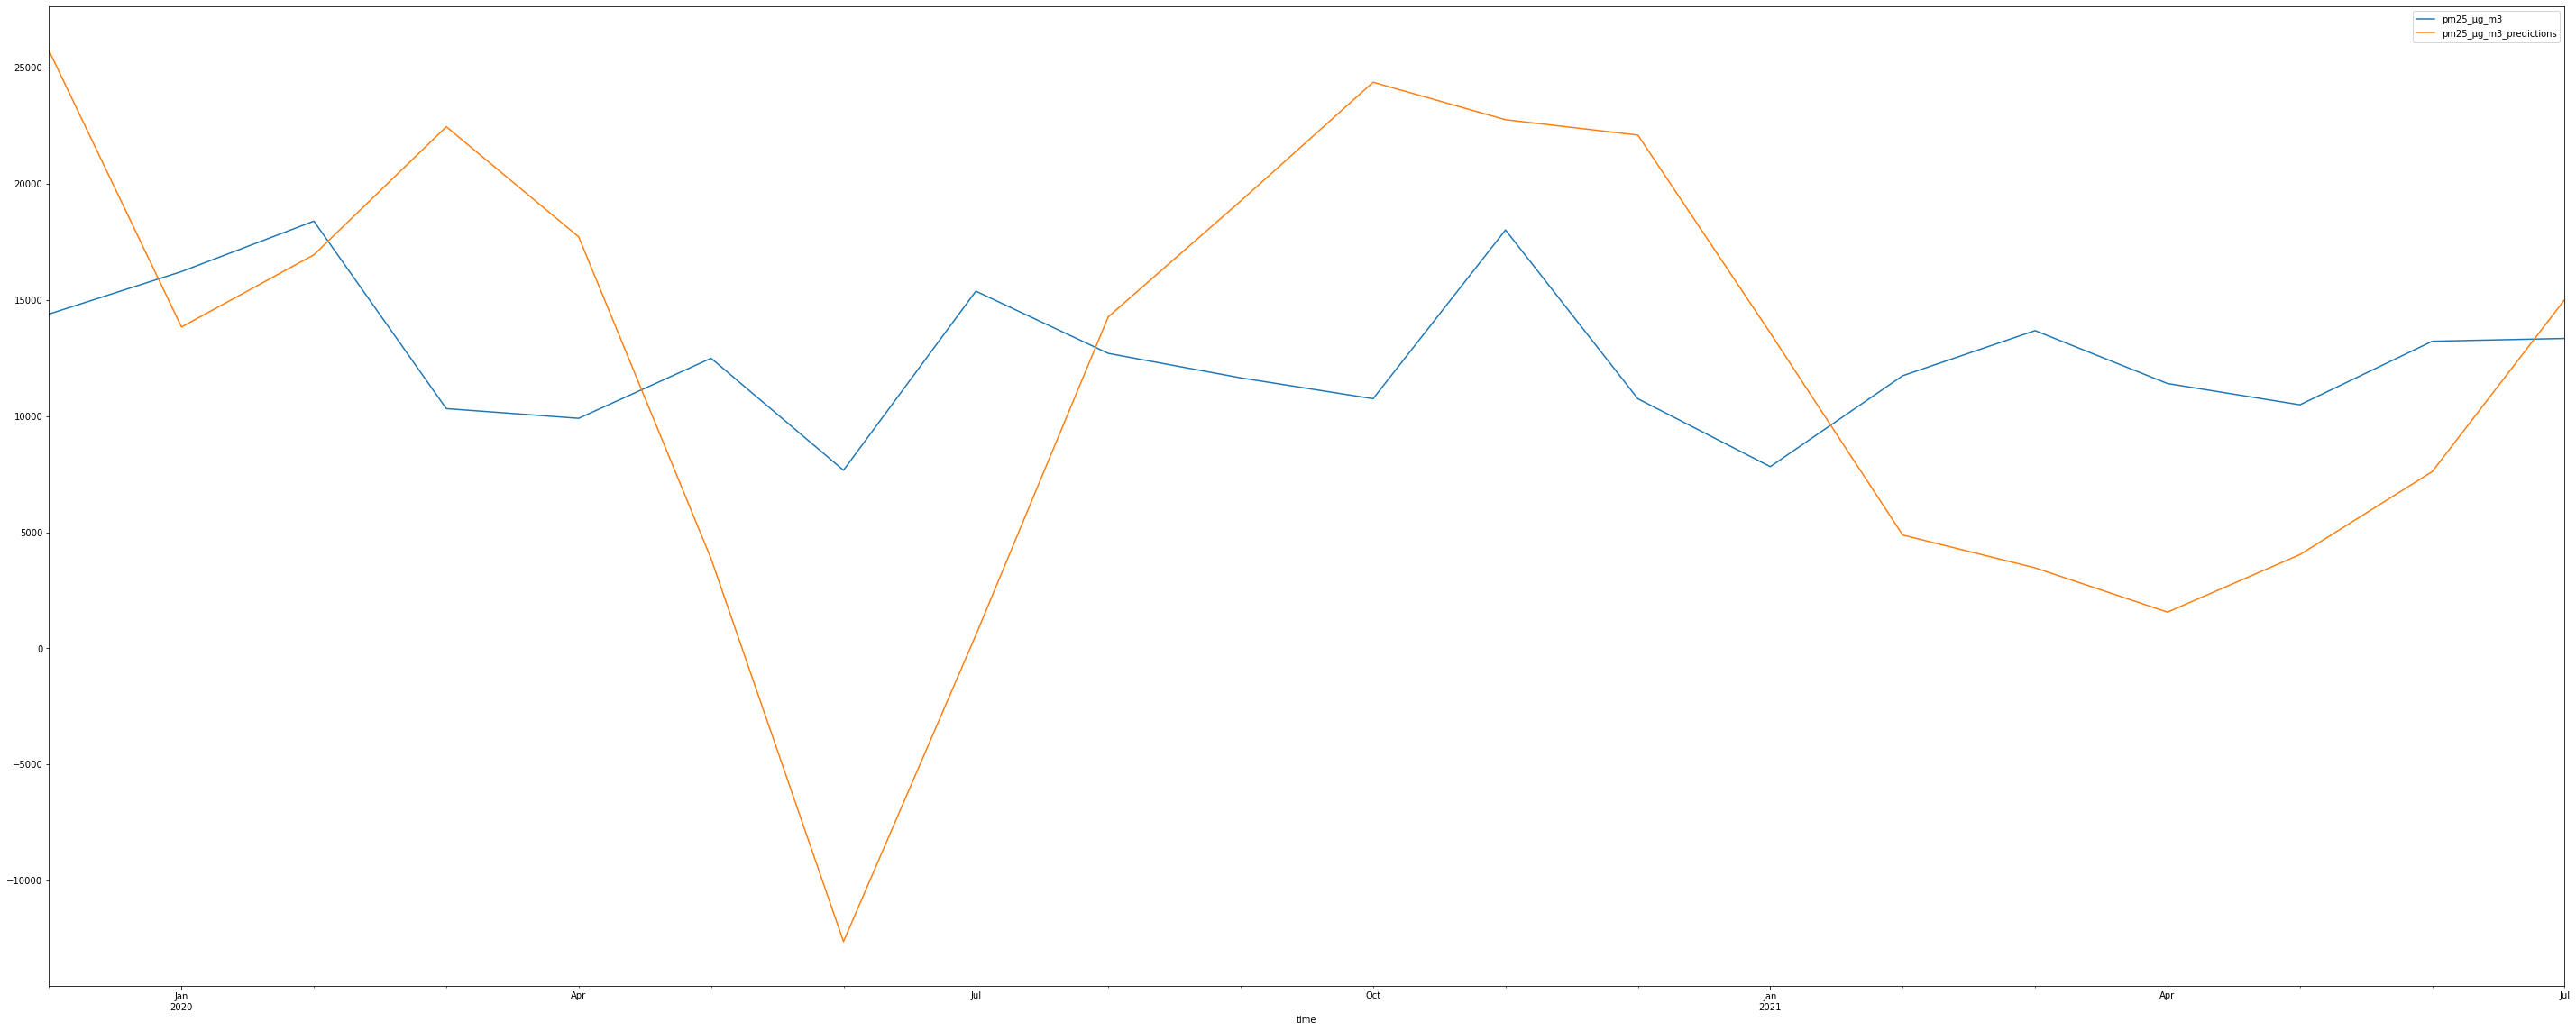

In [836]:
var_model = VARMAX(train, order=(4,0),enforce_stationarity= True)
fitted_model = var_model.fit(disp=False)

n_forecast = pm25_µg_m3_dataframe.shape[0]-len(train)
predict = fitted_model.get_prediction(start=len(train),end=len(train) + n_forecast-1)

predictions=predict.predicted_mean
predictions.columns=["pm25_µg_m3_predictions","traffic_intensity_predictions","traffic_load_predictions","u_wind_component_100m_predictions","surface_pressure_predictions"]
predictions.index = test.index
test_vs_pred=pd.concat([test["pm25_µg_m3"],predictions["pm25_µg_m3_predictions"]],axis=1)
test_vs_pred.plot(figsize=(50,20))

In [837]:
number_of_predictions = test_vs_pred.shape[0]
error = 0
for i in range(number_of_predictions):
    e = abs(test_vs_pred.iloc[i,0]-test_vs_pred.iloc[i,1])
    error += e
print(error)
mean_absolute_error = error/number_of_predictions
print("The mean absolute error of this forecast is ",mean_absolute_error)

164231.2879717111
The mean absolute error of this forecast is  8211.564398585555


## o3_µg_m3

In [838]:
# o3_µg_m3
for i in data.columns:
    print("\n")
    print(f"{i} causes o3_µg_m3")
    print('------------------')
    granger_1 = grangercausalitytests(data[['o3_µg_m3', i]], 4)
    
o3_µg_m3_dataframe = data[["o3_µg_m3","co_mg_m3","no2_µg_m3","no_µg_m3","nox_µg_m3"]]



ben_µg_m3 causes o3_µg_m3
------------------

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.6131  , p=0.0621  , df_denom=60, df_num=1
ssr based chi2 test:   chi2=3.7937  , p=0.0514  , df=1
likelihood ratio test: chi2=3.6839  , p=0.0549  , df=1
parameter F test:         F=3.6131  , p=0.0621  , df_denom=60, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.5918  , p=0.0142  , df_denom=57, df_num=2
ssr based chi2 test:   chi2=9.9893  , p=0.0068  , df=2
likelihood ratio test: chi2=9.2617  , p=0.0097  , df=2
parameter F test:         F=4.5918  , p=0.0142  , df_denom=57, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=5.0896  , p=0.0036  , df_denom=54, df_num=3
ssr based chi2 test:   chi2=17.2481 , p=0.0006  , df=3
likelihood ratio test: chi2=15.1896 , p=0.0017  , df=3
parameter F test:         F=5.0896  , p=0.0036  , df_denom=54, df_num=3

Granger Causality
number of lags (no zero) 4
ssr bas

In [839]:
rows = o3_µg_m3_dataframe.shape[0]
train_rows = int(rows*0.70)
train = o3_µg_m3_dataframe.iloc[:train_rows,:]
test = o3_µg_m3_dataframe.iloc[train_rows:,:]
model = VAR(train,freq = "1M")

In [840]:
sorted_order=model.select_order(maxlags=4)
print(sorted_order.summary())

 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0       92.81       93.02   2.019e+40       92.88
1       90.49      91.76*   2.016e+39       90.95
2       90.83       93.15   3.016e+39       91.67
3       90.57       93.94   2.726e+39       91.79
4      88.79*       93.22  6.507e+38*      90.39*
-------------------------------------------------


<AxesSubplot:xlabel='time'>

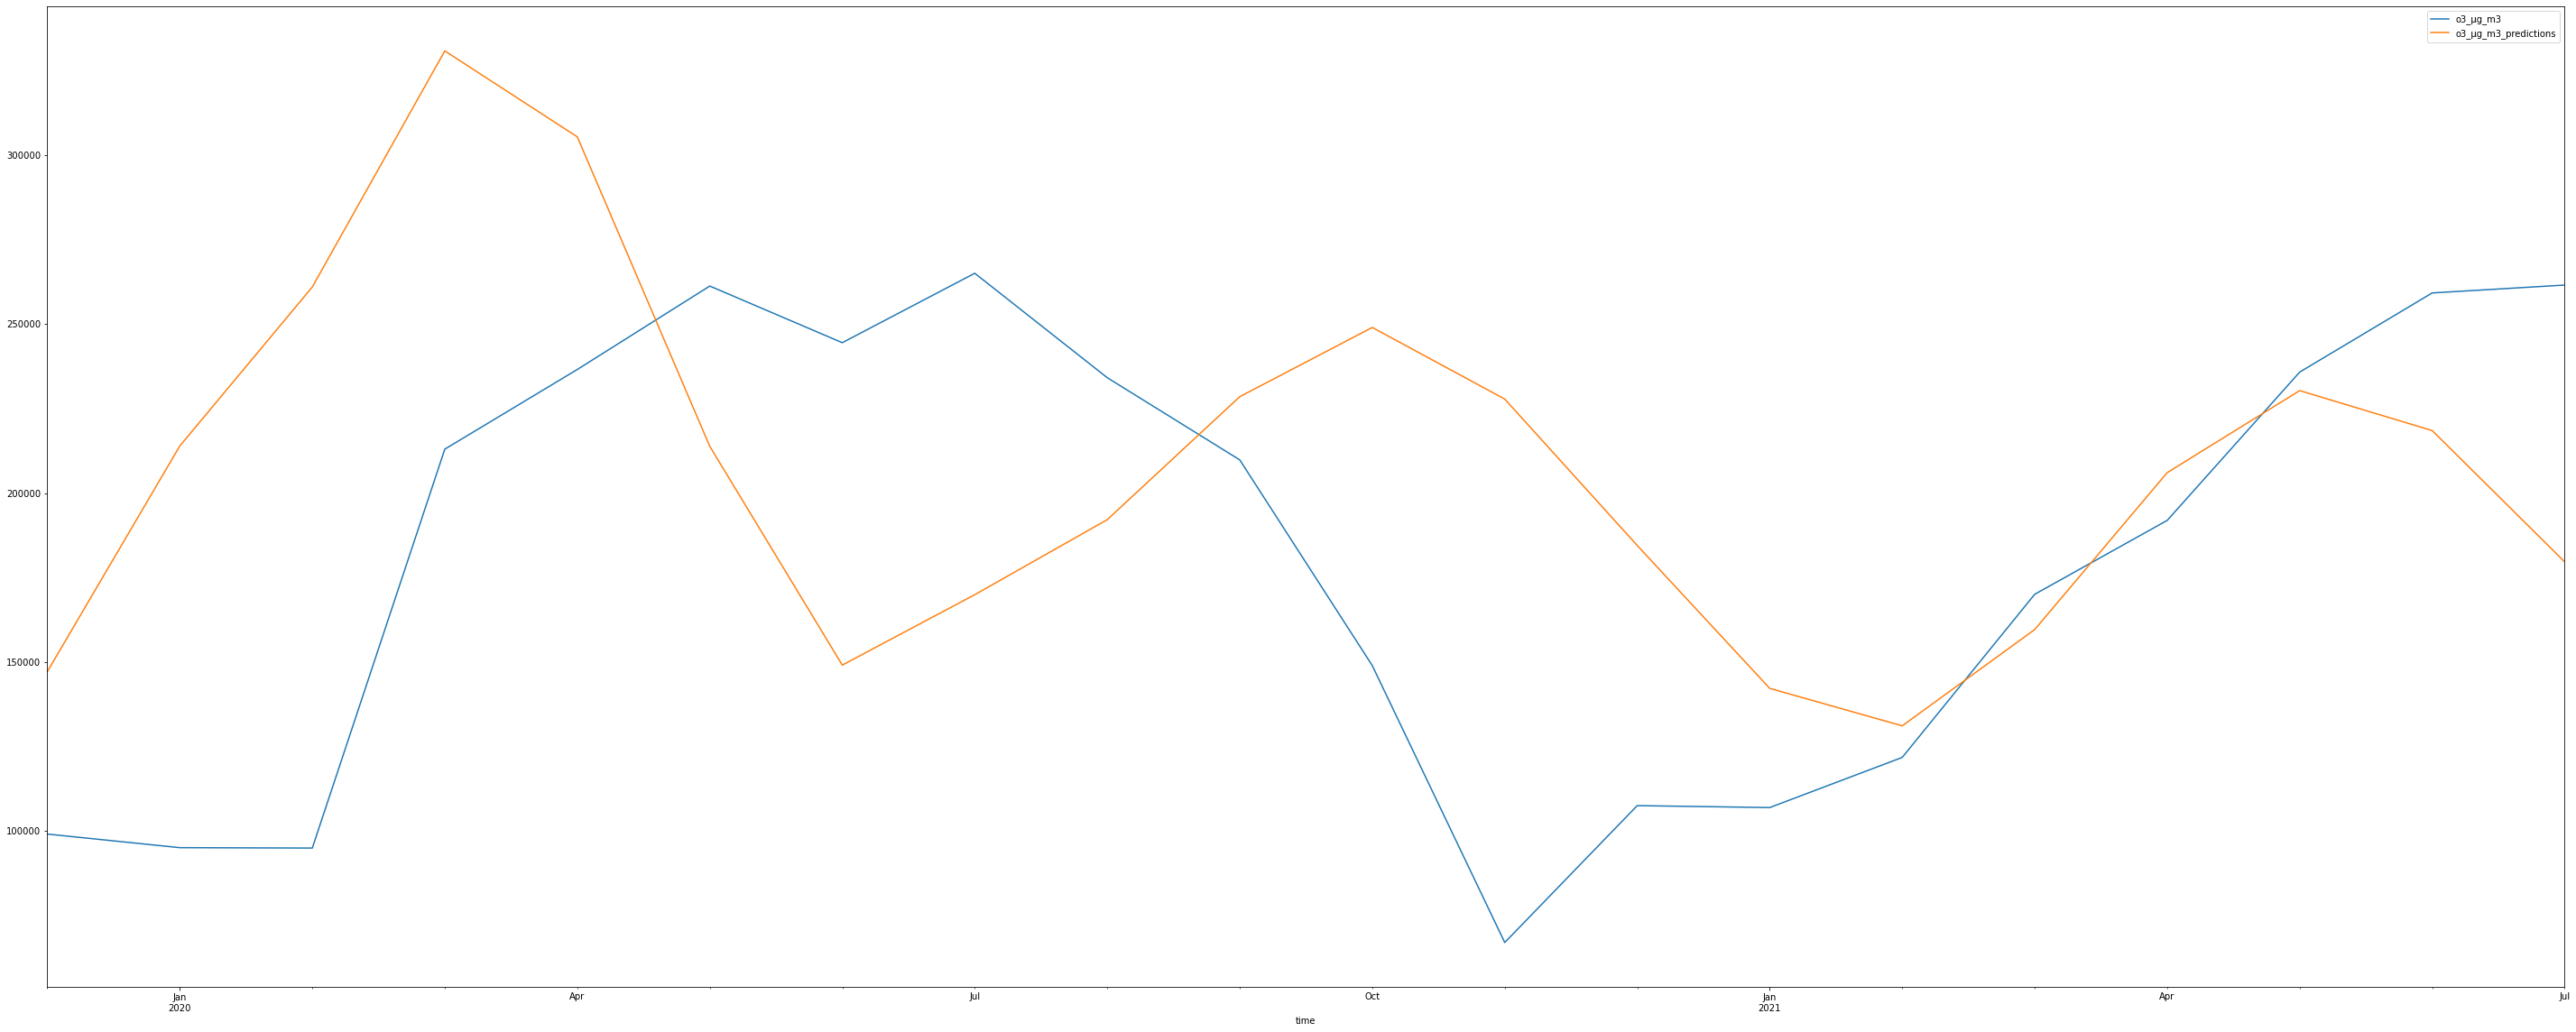

In [841]:
var_model = VARMAX(train, order=(4,0),enforce_stationarity= True)
fitted_model = var_model.fit(disp=False)

n_forecast = o3_µg_m3_dataframe.shape[0]-len(train)
predict = fitted_model.get_prediction(start=len(train),end=len(train) + n_forecast-1)

predictions=predict.predicted_mean
predictions.columns=["o3_µg_m3_predictions","co_mg_m3_predictions","no2_µg_m3_predictions","no_µg_m3_predictions","nox_µg_m3_predictions"]
predictions.index = test.index
test_vs_pred=pd.concat([test["o3_µg_m3"],predictions["o3_µg_m3_predictions"]],axis=1)
test_vs_pred.plot(figsize=(50,20))

In [842]:
number_of_predictions = test_vs_pred.shape[0]
error = 0
for i in range(number_of_predictions):
    e = abs(test_vs_pred.iloc[i,0]-test_vs_pred.iloc[i,1])
    error += e
print(error)
mean_absolute_error = error/number_of_predictions
print("The mean absolute error of this forecast is ",mean_absolute_error)

1353807.0369983607
The mean absolute error of this forecast is  67690.35184991804
